In [10]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
from realism.realism_utils import make_orderbook_for_analysis, MID_PRICE_CUTOFF
from util.plotting import liquidity_telemetry as lt

In [12]:
def get_delays_and_profits(paths):
    output = None
    for path in paths:
        master_profit = None
        delays = {}
        for file in os.listdir(path):
            if 'HerdMasterAgent' in file:
                try:
                    df = pd.read_pickle(os.path.join(path,file), compression='bz2')
                    master_profit = df.loc[df.EventType == 'ENDING_CASH', 'Event'].values[0] - df.loc[df.EventType == 'STARTING_CASH', 'Event'].values[0]
                except (IndexError, KeyError):
                    continue                
            if 'HerdSlaveAgent' in file:
                try:
                    df = pd.read_pickle(os.path.join(path,file), compression='bz2')
                    delay = df.loc[df.EventType == 'DELAY', 'Event'].values[0]
                    profit = df.loc[df.EventType == 'ENDING_CASH', 'Event'].values[0] - df.loc[df.EventType == 'STARTING_CASH', 'Event'].values[0]
                    delays[delay] = profit
                except (IndexError, KeyError):
                    continue
        x, y = np.asarray(sorted(delays.items()))[:, 0], np.asarray(sorted(delays.items()))[:, 1]
        temp = pd.DataFrame({'DELAY': x, 'SLAVE_PROFIT': y})
        temp['MASTER_PROFIT'] = master_profit
        temp['SIMULATION'] = path
        if output is None:
            output = temp
        else:
            output = output.append(temp)
    output['PERCENT'] = output.SLAVE_PROFIT/output.MASTER_PROFIT
    output = output.sort_values(by='DELAY').reset_index(drop=True)
    return output

In [13]:
# end-time 12:00:00
# master-window 1e+9
# slave-min-delay 1e+1 
# slave-max-delay 1e+8
# 1 master
# 40 slaves
# limit orders

# Master Strategy
# if ask < r_f:
#     buy = True
#     p = ask - adjust_int
#     size = self.getHoldings(self.symbol)*(-1) if self.getHoldings(self.symbol) < 0 else self.size
#     if p >= r_f:
#         return
# elif bid > r_f:
#     buy = False
#     p = bid + adjust_int
#     size = self.getHoldings(self.symbol) if self.getHoldings(self.symbol) > 0 else self.size
#     if p <= r_f:
#         return
# if self.currentTime+delta < self.mkt_close:
#     self.placeLimitOrder(self.symbol, size, buy, p)

# Slave Strategy
# if order['is_buy_order']:
#     quantity = order['quantity']
# else:
#     quantity = self.getHoldings(self.symbol) if self.getHoldings(self.symbol) > 0 else order['quantity']
# self.placeLimitOrder(order['symbol'], quantity, order['is_buy_order'], order['limit_price'])



PATHS = ["log/herd01_2_5_hour_0/", "log/herd01_2_5_hour_1/", "log/herd01_2_5_hour_2/", "log/herd01_2_5_hour_3/", 
         "log/herd01_2_5_hour_4/", "log/herd01_2_5_hour_5/"]

df = get_delays_and_profits(PATHS)
df

,DELAY,SLAVE_PROFIT,MASTER_PROFIT,SIMULATION,PERCENT
0,388394.0,199319.0,365427,log/herd01_2_5_hour_1/,0.545441
1,513294.0,34572.0,329913,log/herd01_2_5_hour_4/,0.104791
2,647346.0,87555.0,336637,log/herd01_2_5_hour_0/,0.260087
3,1046636.0,56100.0,329913,log/herd01_2_5_hour_4/,0.170045
4,2081557.0,104077.0,329913,log/herd01_2_5_hour_4/,0.315468
...,...,...,...,...,...
235,97775516.0,42040.0,336637,log/herd01_2_5_hour_0/,0.124882
236,97999578.0,111856.0,365427,log/herd01_2_5_hour_1/,0.306097
237,98847482.0,11855.0,336637,log/herd01_2_5_hour_0/,0.035216
238,98913519.0,25229.0,446145,log/herd01_2_5_hour_5/,0.056549


In [14]:
df['g'] = df.index//30
temp = df.groupby('g').agg(['mean', 'std'])
temp

DELAY                 SLAVE_PROFIT                MASTER_PROFIT  \
           mean           std           mean           std           mean   
g                                                                           
0  5.451039e+06  3.391201e+06  121466.566667  57698.744666  361788.566667   
1  2.011549e+07  5.326870e+06   81153.900000  72623.971065  372454.900000   
2  3.380075e+07  3.182857e+06   39698.833333  49934.195325  368777.700000   
3  4.504049e+07  4.113942e+06   40577.200000  34832.886657  374281.733333   
4  5.614587e+07  4.048804e+06   41396.433333  36005.700262  364933.633333   
5  6.858103e+07  4.457184e+06   34893.200000  30088.166931  373613.100000   
6  8.024152e+07  2.874059e+06   22624.900000  25490.133946  381073.000000   
7  9.225896e+07  4.061049e+06   24295.066667  24807.447112  366336.033333   

                  PERCENT            
            std      mean       std  
g                                    
0  33159.791368  0.335302  0.159015  
1  38049.902468  0.223475  0.212059  
2  39698.989359  0.105323  0.139609  
3  40390.554771  0.107873  0.097397  
4  36776.624928  0.112582  0.101762  
5  41828.035033  0.095524  0.089341  
6  40303.475642  0.059463  0.069428  
7  35891.557875  0.067591  0.071238

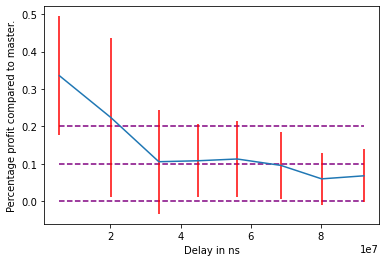

In [15]:
plt.xlabel('Delay in ns')
plt.ylabel('Percentage profit compared to master.')
xmin, xmax= temp.DELAY['mean'].min(), temp.DELAY['mean'].max()
plt.hlines(y=[0, 0.1, 0.2], xmin=[xmin, xmin, xmin], xmax=[xmax, xmax, xmax], colors='purple', linestyles='dashed')
plt.errorbar(temp.DELAY['mean'], temp.PERCENT['mean'], yerr=temp.PERCENT['std'], ecolor='red')  
plt.show()

In [6]:
df = pd.read_pickle('log/herd01_2_5_hour_0/EXCHANGE_AGENT.bz2', compression='bz2')

In [11]:
df[df.EventType == 'ORDER_EXECUTED']

,EventType,Event
EventTime,,
2020-06-03 09:30:00.000038754,ORDER_EXECUTED,"{'agent_id': 5011, 'time_placed': '2020-06-03T..."
2020-06-03 09:30:00.000038754,ORDER_EXECUTED,"{'agent_id': 5075, 'time_placed': '2020-06-03T..."
2020-06-03 09:30:00.000098550,ORDER_EXECUTED,"{'agent_id': 558, 'time_placed': '2020-06-03T0..."
2020-06-03 09:30:00.000098550,ORDER_EXECUTED,"{'agent_id': 5075, 'time_placed': '2020-06-03T..."
2020-06-03 09:30:00.000174037,ORDER_EXECUTED,"{'agent_id': 5009, 'time_placed': '2020-06-03T..."
...,...,...
2020-06-03 11:59:59.841309722,ORDER_EXECUTED,"{'agent_id': 5072, 'time_placed': '2020-06-03T..."
2020-06-03 11:59:59.841309722,ORDER_EXECUTED,"{'agent_id': 5019, 'time_placed': '2020-06-03T..."
2020-06-03 11:59:59.841309722,ORDER_EXECUTED,"{'agent_id': 5046, 'time_placed': '2020-06-03T..."


In [ ]:
_, transacted_orders, _ = lt.create_orderbooks('log/herd01_2_5_hour_0/EXCHANGE_AGENT.bz2',
                                               'log/herd01_2_5_hour_0/ORDERBOOK_ABM_FULL.bz2')

Constructing orderbook...


/home/mazza/abides/util/formatting/convert_order_stream.py:16: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  event_extracted = json_normalize(json_struct)


[                           TIMESTAMP  ORDER_ID   PRICE  SIZE BUY_SELL_FLAG  \
0      2020-06-03 09:30:00.000030850         3  100094    41             1   
1      2020-06-03 09:30:00.000038754         2  100006    21             0   
2      2020-06-03 09:30:00.000049347         5   99995    33             1   
3      2020-06-03 09:30:00.000098550         6  100094    26             0   
4      2020-06-03 09:30:00.000108107         7  100094    27             0   
...                              ...       ...     ...   ...           ...   
310450 2020-06-03 11:59:59.595767713    310453  100027    34          True   
310451 2020-06-03 11:59:59.651769237    310454  100027    39          True   
310452 2020-06-03 11:59:59.841309722    310455  100027    28         False   
310453 2020-06-03 11:59:59.932606212    310456  100028    36         False   
310454 2020-06-03 11:59:59.976590587    310457  100028    38          True   

                Time  Type  
0       34200.000031     1  
1   

Processing order book:  89%|████████▉ | 245877/276311 [02:06<00:20, 1509.44it/s]

In [7]:
# Changed slave strategy to this.


# Slave Strategy
# if order['is_buy_order']:
#     quantity = self.getHoldings(self.symbol) * (-1) if self.getHoldings(self.symbol) < 0 else order['quantity']
# else:
#     quantity = self.getHoldings(self.symbol) if self.getHoldings(self.symbol) > 0 else order['quantity']
# self.placeLimitOrder(order['symbol'], quantity, order['is_buy_order'], order['limit_price'])


PATHS = ["log/herd01_2_5_hour_0_s/", "log/herd01_2_5_hour_1_s/", "log/herd01_2_5_hour_2_s/", "log/herd01_2_5_hour_3_s/", 
         "log/herd01_2_5_hour_4_s/", "log/herd01_2_5_hour_5_s/", "log/herd01_2_5_hour_6_s/"]

df = get_delays_and_profits(PATHS)
df

,DELAY,SLAVE_PROFIT,MASTER_PROFIT,SIMULATION,PERCENT
0,388394.0,108934.0,366561,log/herd01_2_5_hour_1_s/,0.297178
1,456249.0,95516.0,356272,log/herd01_2_5_hour_6_s/,0.268099
2,513294.0,119572.0,329622,log/herd01_2_5_hour_4_s/,0.362755
3,1046636.0,111905.0,329622,log/herd01_2_5_hour_4_s/,0.339495
4,2035991.0,90877.0,356272,log/herd01_2_5_hour_6_s/,0.255078
...,...,...,...,...,...
275,98383093.0,40068.0,322969,log/herd01_2_5_hour_0_s/,0.124061
276,98913519.0,32077.0,413491,log/herd01_2_5_hour_5_s/,0.077576
277,99055962.0,49983.0,322969,log/herd01_2_5_hour_0_s/,0.154761
278,99723573.0,-30457.0,414653,log/herd01_2_5_hour_2_s/,-0.073452


In [8]:
df['g'] = df.index//30
temp = df.groupby('g').agg(['mean', 'std'])
temp

DELAY                SLAVE_PROFIT                MASTER_PROFIT  \
           mean           std          mean           std           mean   
g                                                                          
0  4.056318e+06  2.252467e+06  98140.333333  26769.401159  363407.300000   
1  1.435847e+07  3.694651e+06  74645.866667  37932.847820  364988.966667   
2  2.756487e+07  3.787843e+06  70837.400000  47105.471163  376423.966667   
3  3.764420e+07  2.565958e+06  59831.366667  61388.219196  380583.166667   
4  4.778333e+07  3.249260e+06  65521.500000  44506.499145  374627.233333   
5  6.014319e+07  3.758946e+06  39903.166667  23105.165889  366072.300000   
6  7.077817e+07  3.148552e+06  28915.466667  55494.915863  362583.766667   
7  8.000423e+07  2.660205e+06  16059.300000  45655.992190  381955.100000   
8  9.059479e+07  3.327366e+06  35808.933333  36636.520185  375693.600000   
9  9.838022e+07  9.795903e+05  15495.800000  29337.921512  361377.800000   

                  PERCENT            
            std      mean       std  
g                                    
0  33672.587973  0.272846  0.079810  
1  35166.789540  0.207689  0.108920  
2  35509.387406  0.190438  0.132702  
3  31745.731218  0.158435  0.170857  
4  36004.351688  0.175431  0.118806  
5  37550.526973  0.111713  0.067416  
6  33749.389016  0.082167  0.163390  
7  34434.791285  0.042051  0.128574  
8  34759.966053  0.101450  0.106939  
9  39961.407916  0.046482  0.083767

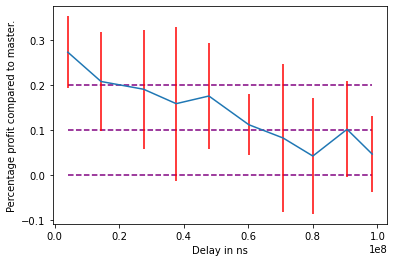

In [9]:
plt.xlabel('Delay in ns')
plt.ylabel('Percentage profit compared to master.')
xmin, xmax= temp.DELAY['mean'].min(), temp.DELAY['mean'].max()
plt.hlines(y=[0, 0.1, 0.2], xmin=[xmin, xmin, xmin], xmax=[xmax, xmax, xmax], colors='purple', linestyles='dashed')
plt.errorbar(temp.DELAY['mean'], temp.PERCENT['mean'], yerr=temp.PERCENT['std'], ecolor='red')  
plt.show()

In [16]:
# Changed slave strategy to this.


# Slave Strategy
# if order['is_buy_order']:
#     quantity = self.getHoldings(self.symbol) * (-1) if self.getHoldings(self.symbol) < 0 else order['quantity']
# else:
#     quantity = self.getHoldings(self.symbol) if self.getHoldings(self.symbol) > 0 else order['quantity']
# self.placeLimitOrder(order['symbol'], quantity, order['is_buy_order'], order['limit_price'])


PATHS = ["log/herd01_2_5_hour_0_t/"]

df = get_delays_and_profits(PATHS)
df

,DELAY,SLAVE_PROFIT,MASTER_PROFIT,SIMULATION,PERCENT
0,460173,0,396767,log/herd01_2_5_hour_0_t/,0.0
1,884209,0,396767,log/herd01_2_5_hour_0_t/,0.0
2,1211229,0,396767,log/herd01_2_5_hour_0_t/,0.0
3,2221647,0,396767,log/herd01_2_5_hour_0_t/,0.0
4,2238192,0,396767,log/herd01_2_5_hour_0_t/,0.0
5,4114884,0,396767,log/herd01_2_5_hour_0_t/,0.0
6,7108258,0,396767,log/herd01_2_5_hour_0_t/,0.0
7,15685811,0,396767,log/herd01_2_5_hour_0_t/,0.0
8,17655615,0,396767,log/herd01_2_5_hour_0_t/,0.0
9,21643176,0,396767,log/herd01_2_5_hour_0_t/,0.0


In [ ]:
# Changed limit orders to market orders.


PATHS = ["log/herd01_2_5_hour_1_t/"]

df = get_delays_and_profits(PATHS)
df